В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

medical_df = pd.read_csv('medical-charges.csv') # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']


In [2]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


In [3]:
non_smoker_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064 entries, 1 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1064 non-null   int64  
 1   sex       1064 non-null   object 
 2   bmi       1064 non-null   float64
 3   children  1064 non-null   int64  
 4   smoker    1064 non-null   object 
 5   region    1064 non-null   object 
 6   charges   1064 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.5+ KB


### 1.1. МНК (з використанням тільки numpy, без scikit learn)

In [4]:
X = non_smoker_df['age']
y = non_smoker_df['charges']

X.shape, y.shape

((1064,), (1064,))

In [5]:
def normal_equations(X,y):
    """Computes the closed-form solution to linear regression"""
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [6]:
# Додаємо колонку одиничок аби задати bias терм (константу в моделі регресії)
X_with_intercept = np.c_[np.ones((X.shape[0], 1)), X]
X[:3], X_with_intercept[:3]

(1    18
 2    28
 3    33
 Name: age, dtype: int64,
 array([[ 1., 18.],
        [ 1., 28.],
        [ 1., 33.]]))

In [7]:
# Коефіцієнти моделі МНК
coefs_MNK = normal_equations(X_with_intercept, y)
w_MNK = coefs_MNK[1]
b_MNK = coefs_MNK[0]

# Прогнози моделі МНК
y_predict_MNK = np.dot(X_with_intercept, coefs_MNK)

# RMSE моделі МНК 
errors_MNK = y - y_predict_MNK
rmse_MNK = np.sqrt(sum(np.array(errors_MNK)**2)/len(errors_MNK))

print('Лінійна регресія, побудована за допомогою МНК та numpy:')
print(f'\t- Коефіцієнти моделі: \tw = {w_MNK:.4f}, b = {b_MNK:.4f}')
print(f'\t- Точність прогнозу: \tRMSE = {rmse_MNK:.4f}')


Лінійна регресія, побудована за допомогою МНК та numpy:
	- Коефіцієнти моделі: 	w = 267.2489, b = -2091.4206
	- Точність прогнозу: 	RMSE = 4662.5058


### 1.2. Full-Batch градієнтний спуск з numpy

In [8]:
X = np.expand_dims(non_smoker_df['age'], axis = 1)

In [9]:
X.shape, y.shape

((1064, 1), (1064,))

In [10]:
# Функція градієнтний спуск
def full_batch_gradient_descent(X, y, lr=0.01, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y)
    errors = []
    for _ in range(epochs):
        y_pred = m * X[:, 0] + b
        error = y_pred - y
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors


Лінійна регресія, побудована за допомогою градієнтного спуску:
	- Коефіцієнти моделі: 	w = -1396762426208284189192631894478196395999232.0000, b = -31448925830775484460463694822921312665600.0000
	- Точність прогнозу: 	RMSE = 58449709239434159796779464230525020753887232.0000


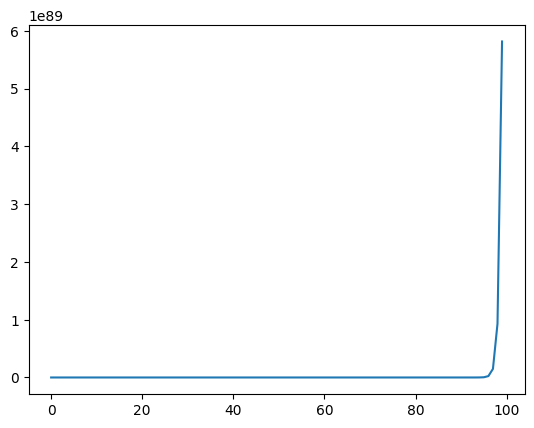

In [11]:
# Градієнтний спуск з навчальним рейтом 0.001
w_FBGD, b_FBGD, errors = full_batch_gradient_descent(X, y, lr=0.001, epochs=100)

y_predict_FBGD = w_FBGD * X[:, 0] + b_FBGD
errors_FBGD = y - y_predict_FBGD
rmse_FBGD = np.sqrt(sum(np.array(errors_FBGD)**2)/len(errors_FBGD))

print('Лінійна регресія, побудована за допомогою градієнтного спуску:')
print(f'\t- Коефіцієнти моделі: \tw = {w_FBGD:.4f}, b = {b_FBGD:.4f}')
print(f'\t- Точність прогнозу: \tRMSE = {rmse_FBGD:.4f}')

plt.plot(errors);

**Висновок**. Як бачимо, градієнтний спуск розходиться навіть з навчальним рейтом **0.001**. Тому далі спробуємо ще менші варіанти. 

Лінійна регресія, побудована за допомогою градієнтного спуску з Learning rate = 0.00010:
	- Коефіцієнти моделі: 	w = 220.1546, b = 0.2130
	- Точність прогнозу: 	RMSE = 4715.3497
Лінійна регресія, побудована за допомогою градієнтного спуску з Learning rate = 0.00005:
	- Коефіцієнти моделі: 	w = 220.1012, b = 2.5824
	- Точність прогнозу: 	RMSE = 4715.4689
Лінійна регресія, побудована за допомогою градієнтного спуску з Learning rate = 0.00001:
	- Коефіцієнти моделі: 	w = 213.8208, b = 4.3394
	- Точність прогнозу: 	RMSE = 4722.7833


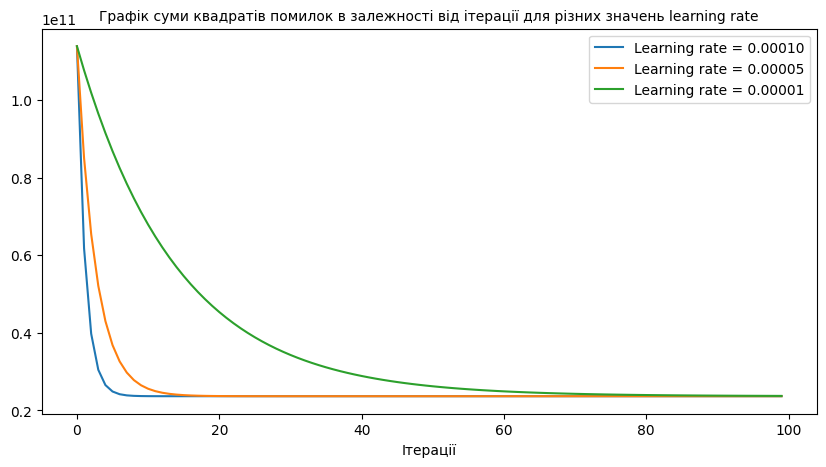

In [12]:
learning_rates = [0.0001, 0.00005, 0.00001]

plt.figure(figsize=(10, 5))
plt.title('Графік суми квадратів помилок в залежності від ітерації для різних значень learning rate', fontsize = 10)
plt.xlabel('Ітерації')

for i in range(len(learning_rates)):
    w_FBGD, b_FBGD, errors = full_batch_gradient_descent(X, y, lr=learning_rates[i], epochs=100)

    y_predict_FBGD = w_FBGD * X[:, 0] + b_FBGD
    errors_FBGD = y - y_predict_FBGD
    rmse_FBGD = np.sqrt(sum(np.array(errors_FBGD)**2)/len(errors_FBGD))

    print(f'Лінійна регресія, побудована за допомогою градієнтного спуску з Learning rate = {learning_rates[i]:.5f}:')
    print(f'\t- Коефіцієнти моделі: \tw = {w_FBGD:.4f}, b = {b_FBGD:.4f}')
    print(f'\t- Точність прогнозу: \tRMSE = {rmse_FBGD:.4f}')
    plt.plot(errors, label = f'Learning rate = {learning_rates[i]:.5f}')
    plt.legend()

**Висновок**. Найкращий результат показав градієнтний спуск з навчальним рейтом **0.0001**, для якого RMSE = 4,715. Але цей результат гірше, ніж ми отримали з МНК.

### 1.3. scikit-learn.LinearRegression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [14]:
X = non_smoker_df['age'].to_frame()
X.shape

(1064, 1)

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [16]:
# Коефіцієнти моделі лінійної регресії sklearn

w_LinReg_sklearn = lin_reg.coef_
b_LinReg_sklearn = lin_reg.intercept_

# Прогнози моделі лінійної регресії sklearn
y_predict_LinReg_sklearn = lin_reg.predict(X)

# RMSE моделі лінійної регресії sklearn
errors_LinReg_sklearn = y - y_predict_LinReg_sklearn
rmse_LinReg_sklearn = root_mean_squared_error(y, y_predict_LinReg_sklearn)

print('Лінійна регресія, побудована за допомогою sklearn:')
print(f'\t- Коефіцієнти моделі: \tw = {w_LinReg_sklearn[0]:.4f}, b = {b_LinReg_sklearn:.4f}')
print(f'\t- Точність прогнозу: \tRMSE = {rmse_LinReg_sklearn:.4f}')

Лінійна регресія, побудована за допомогою sklearn:
	- Коефіцієнти моделі: 	w = 267.2489, b = -2091.4206
	- Точність прогнозу: 	RMSE = 4662.5058


### 1.4. Візуалізація результатів

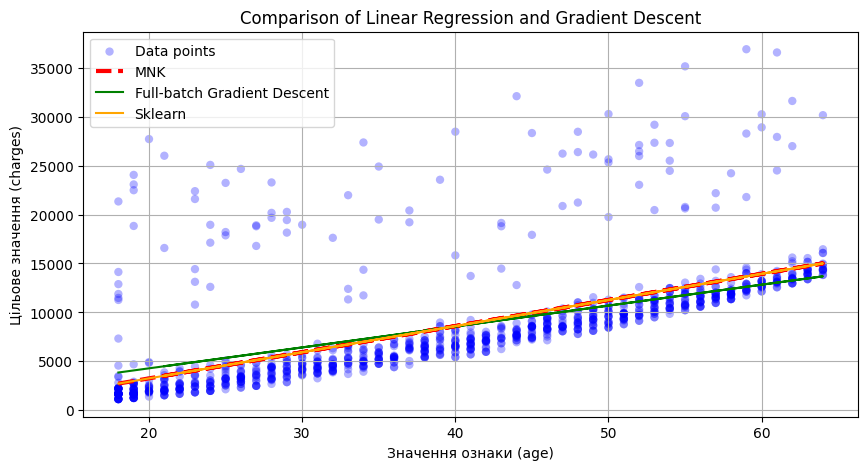

In [17]:
# Візуалізація результатів
plt.figure(figsize=(10, 5))
plt.scatter(X, y, color='blue', label='Data points', alpha = 0.3, edgecolors = 'none')
plt.plot(X, y_predict_MNK, color='red', linestyle = 'dashed', label='MNK', linewidth = 3)
plt.plot(X, y_predict_FBGD, color='green', label='Full-batch Gradient Descent')
plt.plot(X, y_predict_LinReg_sklearn, color='orange', label='Sklearn')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки (age)')
plt.ylabel('Цільове значення (charges)')
plt.legend()
plt.grid(True)
plt.show()

**Висновок**. Найкращу точність показав метод найменших квадратів, який також використовується в лінійній регресії з бібліотеки sklearn (w = 267, b = -2,091, RMSE = 4,663). Градієнтний спуск (FBXG) в даному випадку спрацював гірше (w = 220, b = 0.2, RMSE = 4,715). RMSE моделі лінійної регресії, побудованої в минулому домашньому завданні простим методом підбору коефіцієнтів, не набагато менше ніж отримане методом FBXG, хоча коефіцієнти відрізняються (w = 300, b = -4000, RMSE = 4,726).

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [18]:
smoker_df = medical_df[medical_df.smoker == 'yes']

In [19]:
smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [20]:
smoker_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,274.0,38.514599,13.923186,18.0000,27.000000,38.00000,49.000000,64.00000
bmi,274.0,30.708449,6.318644,17.1950,26.083750,30.44750,35.200000,52.58000
children,274.0,1.113139,1.157066,0.0000,0.000000,1.00000,2.000000,5.00000
charges,274.0,32050.231832,11541.547176,12829.4551,20826.244213,34456.34845,41019.207275,63770.42801


In [21]:
X = smoker_df['age'].to_frame()
y = smoker_df['charges']

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

Лінійна регресія, побудована за допомогою sklearn:
	- Коефіцієнти моделі: 	w = 305.2376, b = 20294.1281
	- Точність прогнозу: 	RMSE = 10711.0033


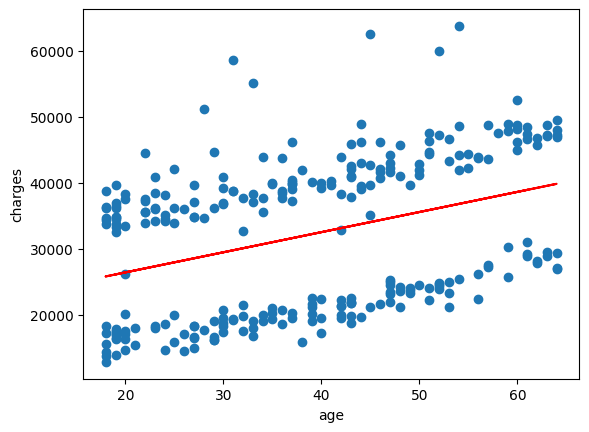

In [23]:
# Коефіцієнти моделі лінійної регресії sklearn
w = lin_reg.coef_
b = lin_reg.intercept_

# Прогнози моделі лінійної регресії sklearn
y_predict = lin_reg.predict(X)

# RMSE моделі лінійної регресії sklearn
errors = y - y_predict
rmse = root_mean_squared_error(y, y_predict)

print('Лінійна регресія, побудована за допомогою sklearn:')
print(f'\t- Коефіцієнти моделі: \tw = {w[0]:.4f}, b = {b:.4f}')
print(f'\t- Точність прогнозу: \tRMSE = {rmse:.4f}')

# Візуалізація лінійної регресії на графіку розсіювання age проти charges
plt.scatter(X, y)
plt.plot(X, y_predict, color = 'red')
plt.xlabel('age')
plt.ylabel('charges')
plt.show()

**Висновок**. RMSE нашої моделі дорівнює 10711, що трохи менше за стандартне відхилення charges (11541). Як ми можемо бачити з графіка розсіювання, наша лінія регресії проходить між двома областями з великою щільністю даних, тому похибки будуть досить великі для обох кластерів. Можливо існує ще якийсь фактор, що спричиняє такий розподіл. Якщо врахувати його, то можна отримати більш точний прогноз. Спробуємо додати на графік розсіювання значення bmi, щоб перевірити наше припущення.

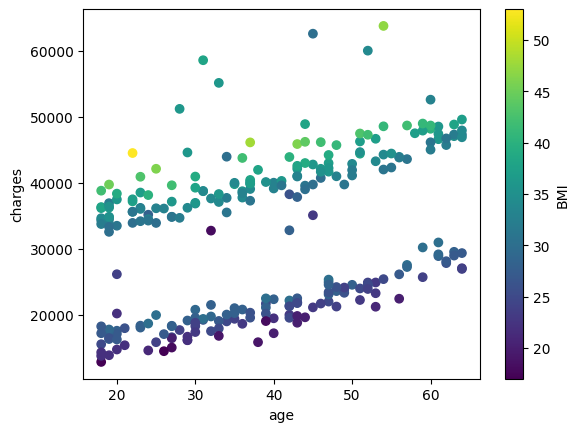

In [24]:
colors = smoker_df['bmi'].round(0)
plt.scatter(smoker_df.age, smoker_df.charges, c = colors, cmap = 'viridis')
plt.xlabel('age')
plt.ylabel('charges')
plt.colorbar(label = 'BMI')
plt.show()

Як ми бачимо, існує чітка залежність виплат для курців не тільки від віку, а й від значення bmi (чим вище bmi, тим більше charges). Спробуємо побудувати 3 версії лінійної регресії (1. age, 2. bmi, 3. age та bmi) та порівняємо їх RMSE.

In [25]:
def LinReg_smoker(df: pd.DataFrame, X_col: list, y_col):
    X = df[X_col]
    y = df[y_col]
    model = LinearRegression()
    model.fit(X, y)
    y_predict = model.predict(X)
    rmse = root_mean_squared_error(y, y_predict)
    print(f'RMSE {X_col} = {rmse:.4f}')
    return y_predict, rmse

In [26]:
y_predict_age, rmse_age = LinReg_smoker(smoker_df, ['age'], 'charges')
y_predict_bmi, rmse_bmi = LinReg_smoker(smoker_df, ['bmi'], 'charges')
y_predict_age_bmi, rmse_bmi = LinReg_smoker(smoker_df, ['age', 'bmi'], 'charges')

RMSE ['age'] = 10711.0033
RMSE ['bmi'] = 6811.5974
RMSE ['age', 'bmi'] = 5722.7822


**Висновок**. Як ми бачимо, модель, яка використовує тільки значення **bmi**, має набагато кращий RMSE ніж модель, яка використовує **age**. Тобто, якщо існує можливість використовувати для передбачень **charges** для курців тільки модель з однією змінною, то краще орієнтуватися на **bmi** (індекс маси тіла), а не на **age** (вік клієнта). Ще більшу точність ми отримаємо, якщо додамо в модель не один, а обидва параметри (bmi та age), але це вже буде лінійна регресія від кількох змінних, хоч і зовсім проста.